In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy import interpolate
from scipy.stats import linregress

home_dir = '/glade/work/devond/'

import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
### ----- Read ICE SHEET MASK data ----- ###

cesm_mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(cesm_mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))
cesm_area = cesm_masks.area.values #grid cell areas
cesm_ism = cesm_masks.full_ism.values
cesm_gism = cesm_masks.grounded_ism.values

cesm_iceshelves = xr.open_dataset('/glade/work/devond/AIS_masks/iceshelfmask_CESM2.nc')
cesm_iceshelves = cesm_iceshelves.sel(latitude = slice(-90,-60))
cesm_shelves = cesm_iceshelves.ism.values
cesm_shelves[cesm_shelves==0]=np.nan

In [3]:
cesm_cmip_snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM2_SNOW_hist.nc')
cesm_cmip_rain = xr.load_dataset(f'{home_dir}CESM/rain/CESM2_RAIN_hist.nc')
cesm_cmip_subl = xr.load_dataset(f'{home_dir}CESM/evap_subl/CESM2_QSOIL_ICE_hist.nc')
cesm_cmip_runoff = xr.load_dataset(f'{home_dir}CESM/runoff/CESM2_QRUNOFF_ICE_hist.nc')

hist_smb = (cesm_cmip_snow.SNOW + cesm_cmip_rain.RAIN - cesm_cmip_subl['QSOIL_ICE'] - cesm_cmip_runoff['QRUNOFF_ICE']).mean(dim = 'ensemble')
hist_smb = hist_smb * 3600*24*hist_smb.time.dt.days_in_month

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
hist_smb_g = (hist_smb*cesm_gism*cesm_area).sel(time = slice('1985-01-01', '2014-12-31'))
hist_smb_g = hist_smb_g.groupby(hist_smb_g.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

hist_smb_is = (hist_smb*cesm_shelves*cesm_area).sel(time = slice('1985-01-01', '2014-12-31'))
hist_smb_is = hist_smb_is.groupby(hist_smb_is.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

In [5]:
## SSP1
ssp1_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP1-2.6_2.nc')
ssp1_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP1-2.6_2.nc')
ssp1_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP1-2.6_2.nc')
ssp1_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP1-2.6.nc')

ssp1_smb = (ssp1_snow.SNOW + ssp1_rain.RAIN - ssp1_evap.QSOIL - ssp1_runoff.QRUNOFF).mean(dim = 'ensemble')
ssp1_smb = ssp1_smb * 3600*24*ssp1_smb.time.dt.days_in_month

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
ssp1_smb_g = (ssp1_smb*cesm_gism*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp1_smb_g = ssp1_smb_g.groupby(ssp1_smb_g.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

ssp1_smb_is = (ssp1_smb*cesm_shelves*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp1_smb_is = ssp1_smb_is.groupby(ssp1_smb_is.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)


In [7]:
## SSP3
ssp3_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP3-7.0_2.nc')
ssp3_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP3-7.0_2.nc')
ssp3_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP3-7.0_2.nc')
ssp3_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP3-7.0.nc')

ssp3_smb = (ssp3_snow.SNOW + ssp3_rain.RAIN - ssp3_evap.QSOIL - ssp3_runoff.QRUNOFF).mean(dim = 'ensemble')
ssp3_smb = ssp3_smb * 3600*24*ssp3_smb.time.dt.days_in_month

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
ssp3_smb_g = (ssp3_smb*cesm_gism*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp3_smb_g = ssp3_smb_g.groupby(ssp3_smb_g.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

ssp3_smb_is = (ssp3_smb*cesm_shelves*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp3_smb_is = ssp3_smb_is.groupby(ssp3_smb_is.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)


In [9]:
## SSP5
ssp5_snow = xr.load_dataset(f'/glade/work/devond/CESM/snow/CESM2_SNOW_SSP5-8.5_2.nc')
ssp5_rain = xr.load_dataset(f'/glade/work/devond/CESM/rain/CESM2_RAIN_SSP5-8.5_2.nc')
ssp5_evap = xr.load_dataset(f'/glade/work/devond/CESM/evap_subl/CESM2_QSOIL_SSP5-8.5_2.nc')
ssp5_runoff = xr.load_dataset(f'/glade/work/devond/CESM/runoff/CESM2_QRUNOFF_SSP5-8.5.nc')

ssp5_smb = (ssp5_snow.SNOW + ssp5_rain.RAIN - ssp5_evap.QSOIL - ssp5_runoff.QRUNOFF).mean(dim = 'ensemble')
ssp5_smb = ssp5_smb * 3600*24*ssp5_smb.time.dt.days_in_month

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
ssp5_smb_g = (ssp5_smb*cesm_gism*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp5_smb_g = ssp5_smb_g.groupby(ssp5_smb_g.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)

ssp5_smb_is = (ssp5_smb*cesm_shelves*cesm_area).sel(time = slice('2071-01-01', '2100-12-31'))
ssp5_smb_is = ssp5_smb_is.groupby(ssp5_smb_is.time.dt.month).mean().sum(dim = ['lat', 'lon'])/(10**12)


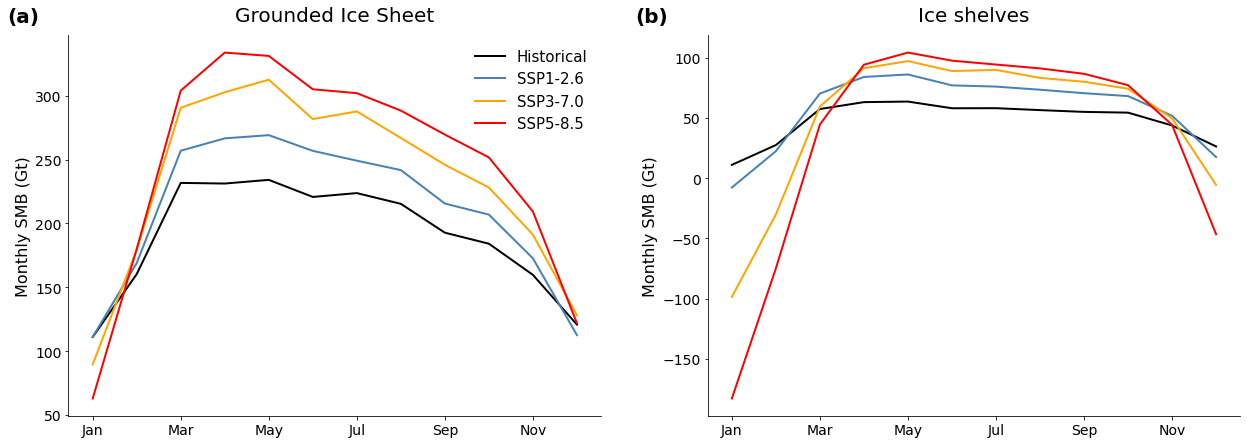

In [11]:
fig,ax = plt.subplots(1,2,figsize = (21,7))
plt.rcParams['axes.titlepad'] =14

ax[0].plot(hist_smb_g, color = 'black', linewidth = 2)
ax[0].plot(ssp1_smb_g, color = 'steelblue', linewidth = 2)
ax[0].plot(ssp3_smb_g, color = 'orange', linewidth = 2)
ax[0].plot(ssp5_smb_g, color = 'red', linewidth = 2)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].tick_params(labelsize=14)
ax[0].set_xticks([0,2,4,6,8,10])
ax[0].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])
ax[0].set_ylabel('Monthly SMB (Gt)', fontsize = 16)
ax[0].set_title('Grounded Ice Sheet', fontsize = 20)
ax[0].legend(['Historical', 'SSP1-2.6', 'SSP3-7.0', 'SSP5-8.5'], frameon = False, prop={'size':15})
ax[0].text(-0.055, 1.075, '(a)', transform=ax[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax[1].plot(hist_smb_is, color = 'black', linewidth = 2)
ax[1].plot(ssp1_smb_is, color = 'steelblue', linewidth = 2)
ax[1].plot(ssp3_smb_is, color = 'orange', linewidth = 2)
ax[1].plot(ssp5_smb_is, color = 'red', linewidth = 2)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].tick_params(labelsize=14)
ax[1].set_xticks([0,2,4,6,8,10])
ax[1].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])
ax[1].set_ylabel('Monthly SMB (Gt)', fontsize = 16)
ax[1].set_title('Ice shelves', fontsize = 20)
ax[1].text(-0.075, 1.075, '(b)', transform=ax[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.savefig('smb_future_seasonality.png', dpi=300, bbox_inches='tight')

In [37]:
ssp5_smb_g.sel(month = [1,2,12]).mean()


<xarray.DataArray ()>
array(121.65560061)